In [ ]:
!pip install git+https://github.com/neelnanda-io/TransformerLens

In [1]:
from transformer_lens import HookedTransformer, utils
model  = HookedTransformer.from_pretrained("gpt2-small")

/home/TeAmP0is0N/anaconda3/envs/lens/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loaded pretrained model gpt2-small into HookedTransformer


In [2]:
logits = model("Famous computer scientist Alan")
# the logit dimensions are: [batch, position, vocab]
next_token_logits = logits[0, -1]
next_token_prediction = next_token_logits.argmax()
next_word_prediction = model.tokenizer.decode(next_token_prediction)
print(next_word_prediction)

 Turing


Now let's have a look at the internal activations:

In [3]:
logits, cache = model.run_with_cache("Famous computer scientist Alan")
for key, value in cache.items():
    print(key, value.shape)

hook_embed torch.Size([1, 6, 768])
hook_pos_embed torch.Size([1, 6, 768])
blocks.0.hook_resid_pre torch.Size([1, 6, 768])
blocks.0.ln1.hook_scale torch.Size([1, 6, 1])
blocks.0.ln1.hook_normalized torch.Size([1, 6, 768])
blocks.0.attn.hook_q torch.Size([1, 6, 12, 64])
blocks.0.attn.hook_k torch.Size([1, 6, 12, 64])
blocks.0.attn.hook_v torch.Size([1, 6, 12, 64])
blocks.0.attn.hook_attn_scores torch.Size([1, 12, 6, 6])
blocks.0.attn.hook_pattern torch.Size([1, 12, 6, 6])
blocks.0.attn.hook_z torch.Size([1, 6, 12, 64])
blocks.0.hook_attn_out torch.Size([1, 6, 768])
blocks.0.hook_resid_mid torch.Size([1, 6, 768])
blocks.0.ln2.hook_scale torch.Size([1, 6, 1])
blocks.0.ln2.hook_normalized torch.Size([1, 6, 768])
blocks.0.mlp.hook_pre torch.Size([1, 6, 3072])
blocks.0.mlp.hook_post torch.Size([1, 6, 3072])
blocks.0.hook_mlp_out torch.Size([1, 6, 768])
blocks.0.hook_resid_post torch.Size([1, 6, 768])
blocks.1.hook_resid_pre torch.Size([1, 6, 768])
blocks.1.ln1.hook_scale torch.Size([1, 6, 1])

In [ ]:
model.named_parameters()

# TODO
# What can the unembedding biases `unembed.b_U` tell you about common tokens?

In [4]:
# now let's start analysing a behaviour

utils.test_prompt("Her name was Alex Hart. Tomorrow at lunch time Alex",
                 " Hart", model)

Tokenized prompt: ['<|endoftext|>', 'Her', ' name', ' was', ' Alex', ' Hart', '.', ' Tomorrow', ' at', ' lunch', ' time', ' Alex']
Tokenized answer: [' Hart']


Performance on answer token:
Rank: 3        Logit: 14.29 Prob:  7.35% Token: | Hart|

Top 0th token. Logit: 15.64 Prob: 28.38% Token: | will|
Top 1th token. Logit: 14.47 Prob:  8.79% Token: | would|
Top 2th token. Logit: 14.34 Prob:  7.74% Token: | was|
Top 3th token. Logit: 14.29 Prob:  7.35% Token: | Hart|
Top 4th token. Logit: 14.18 Prob:  6.54% Token: | and|
Top 5th token. Logit: 14.09 Prob:  6.00% Token: | is|
Top 6th token. Logit: 13.51 Prob:  3.38% Token: |'s|
Top 7th token. Logit: 13.23 Prob:  2.53% Token: |,|
Top 8th token. Logit: 12.73 Prob:  1.55% Token: | had|
Top 9th token. Logit: 12.00 Prob:  0.74% Token: | has|


Ranks of the answer tokens: [(' Hart', 3)]

# Method 1: Residual Stream Patching

In [6]:
model.reset_hooks()
_, corrupt_cache = model.run_with_cache("Her name was Alex Carroll. Tomorrow at lunch time Alex")

In [7]:
def patch_residual_stream(activations, hook, layer="blocks.6.hook_resid_post", pos=5):
    # The residual stream dimensions are [batch, position, d_embed]
    activations[:, pos, :] = corrupt_cache[layer][:, pos, :]
    return activations

# add_hook takes 2 args: Where to insert the patch,
# and the function providing the updates activations
model.add_hook("blocks.6.hook_resid_post", patch_residual_stream)

In [8]:
utils.test_prompt("Her name was Alex Hart. Tomorrow at lunch time Alex", "Hart", model)

Tokenized prompt: ['<|endoftext|>', 'Her', ' name', ' was', ' Alex', ' Hart', '.', ' Tomorrow', ' at', ' lunch', ' time', ' Alex']
Tokenized answer: [' Hart']


Performance on answer token:
Rank: 1920     Logit:  5.48 Prob:  0.00% Token: | Hart|

Top 0th token. Logit: 15.67 Prob: 30.92% Token: | will|
Top 1th token. Logit: 14.41 Prob:  8.78% Token: | was|
Top 2th token. Logit: 14.07 Prob:  6.26% Token: | is|
Top 3th token. Logit: 14.03 Prob:  6.01% Token: | Carroll|
Top 4th token. Logit: 14.02 Prob:  5.96% Token: | would|
Top 5th token. Logit: 14.02 Prob:  5.95% Token: | and|
Top 6th token. Logit: 13.45 Prob:  3.36% Token: |'s|
Top 7th token. Logit: 13.07 Prob:  2.30% Token: |,|
Top 8th token. Logit: 12.60 Prob:  1.45% Token: | had|
Top 9th token. Logit: 11.96 Prob:  0.76% Token: | has|


Ranks of the answer tokens: [(' Hart', 1920)]

In [9]:
model.reset_hooks()

In [10]:
model = HookedTransformer.from_pretrained("solu-6l")

config.json: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.27k/1.27k [00:00<00:00, 319kB/s]
model_final.pth: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 476M/476M [00:13<00:00, 35.7MB/s]
tokenizer_config.json: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51.0/51.0 [00:00<00:00, 4.30kB/s]
tokenizer.json: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2.04M/2.04M [00:00<00:00, 4.87MB/s]
special_tokens_map.json: 100%|██████████████████████████████████████████████████████

Loaded pretrained model solu-6l into HookedTransformer


In [18]:
import torch
from functools import partial

model_6l = HookedTransformer.from_pretrained("solu-6l")

# Clean and corrupt prompts in variables
clean_prompt = "Her name was Alex Hart. Tomorrow at lunch time Alex"
corrupt_prompt = "Her name was Alex Carroll. Tomorrow at lunch time Alex"
# Get the list of tokens the model will deal with
clean_tokens = model_6l.to_str_tokens(clean_prompt)
# Indices of the right and wrong answers (last names) to judge what the model predicts
_, corrupt_cache_6l = model_6l.run_with_cache(corrupt_prompt)

def patch_residual_stream(activations, hook, layer="blocks.6.hook_resid_post", pos=5):
   # The residual stream dimensions are [batch, position, d_embed]
   activations[:, pos, :] = corrupt_cache_6l[layer][:, pos, :]
   return activations

# List of layers and positions to iterate over. We want to patch before the
# first layer, and after every layer (so we cover 13 positions in total).
layers = ["blocks.0.hook_resid_pre", *[f"blocks.{i}.hook_resid_post" for i in range(model_6l.cfg.n_layers)]]
n_layers = len(layers)
n_pos = len(clean_tokens)

# Indices of the right and wrong answers (last names) to judge what the model predicts
clean_answer_index = model_6l.tokenizer.encode(" Hart")[0]
corrupt_answer_index = model_6l.tokenizer.encode(" Carroll")[0]

# Test the effect of  this patch at any layer and any position
patching_effect = torch.zeros(n_layers, n_pos)
for l, layer in enumerate(layers):
    print("Patching layer", l)
    for pos in range(n_pos):
        fwd_hooks = [(layer, partial(patch_residual_stream, layer=layer, pos=pos))]
        prediction_logits = model_6l.run_with_hooks(clean_prompt,
                                                    fwd_hooks=fwd_hooks)[0, -1]
        patching_effect[l, pos] = prediction_logits[clean_answer_index] \
                                  - prediction_logits[corrupt_answer_index]

torch.cuda.empty_cache()

Loaded pretrained model solu-6l into HookedTransformer
Patching layer 0
Patching layer 1
Patching layer 2
Patching layer 3
Patching layer 4
Patching layer 5
Patching layer 6


In [25]:
import plotly.express as px

def imshow(
    tensor,
    xlabel="X",
    ylabel="Y",
    zlabel=None,
    xticks=None,
    yticks=None,
    c_midpoint=0.0,
    c_scale="RdBu",
    show=True,
    **kwargs
):
    tensor = utils.to_numpy(tensor)
    xticks = [str(x) for x in xticks]
    yticks = [str(y) for y in yticks]
    labels = {"x": xlabel, "y": ylabel}
    if zlabel is not None:
        labels["color"] = zlabel
    fig = px.imshow(
        tensor,
        x=xticks,
        y=yticks,
        labels=labels,
        color_continuous_midpoint=c_midpoint,
        color_continuous_scale=c_scale,
        **kwargs
    ).show()

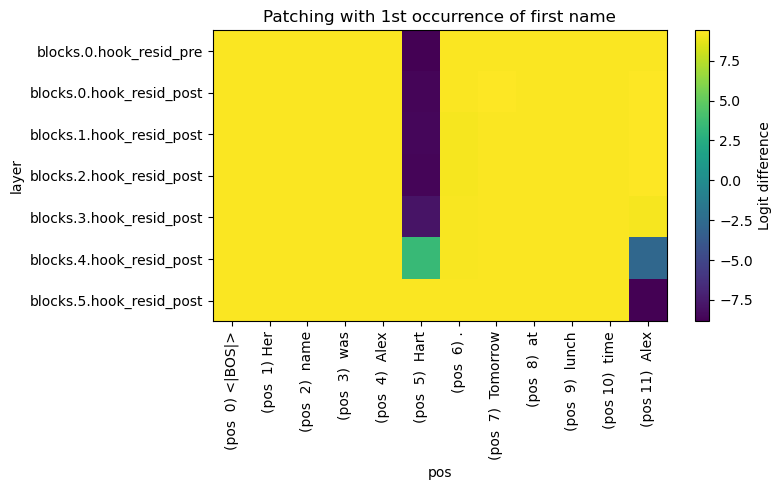

In [26]:
import matplotlib.pyplot as plt

# Your existing code for token_labels
token_labels = [f"(pos {i:2}) {t}" for i, t in enumerate(clean_tokens)]

# Assuming 'layers' is a list of labels for the y-axis
# and 'patching_effect' is a 2D array or similar

# Assuming 'patching_effect' is a PyTorch tensor that requires grad
patching_effect_np = patching_effect.detach().numpy()  # Convert to NumPy array after detaching

# Now you can use patching_effect_np with matplotlib
plt.figure(figsize=(8, 5))
plt.imshow(patching_effect_np, aspect='auto')  # Use the NumPy array here

plt.xticks(ticks=range(len(token_labels)), labels=token_labels, rotation='vertical')
plt.yticks(ticks=range(len(layers)), labels=layers)
plt.xlabel("pos")
plt.ylabel("layer")
plt.colorbar(label="Logit difference")
plt.title("Patching with 1st occurrence of first name")

plt.tight_layout()
plt.show()

Loaded pretrained model gelu-2l into HookedTransformer


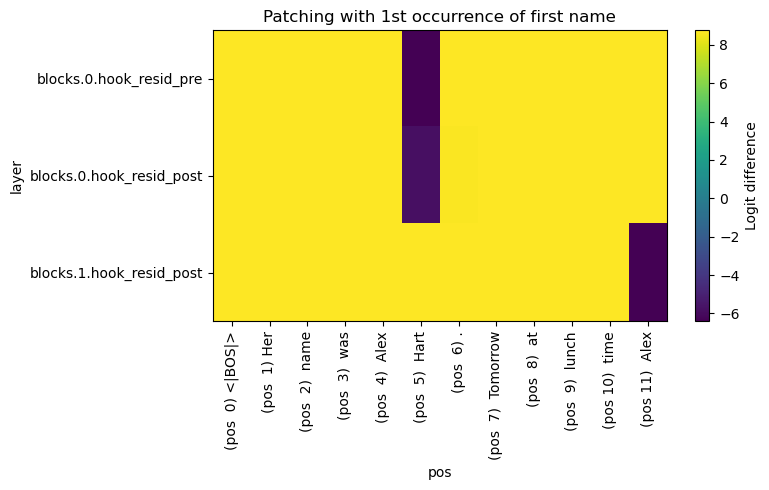

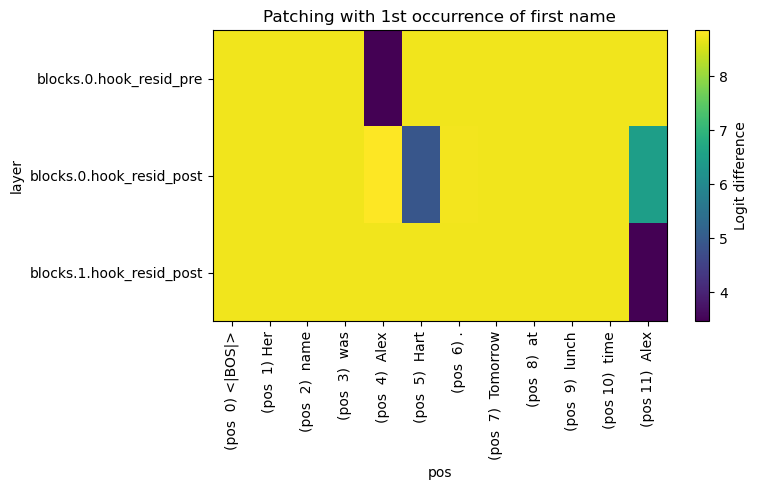

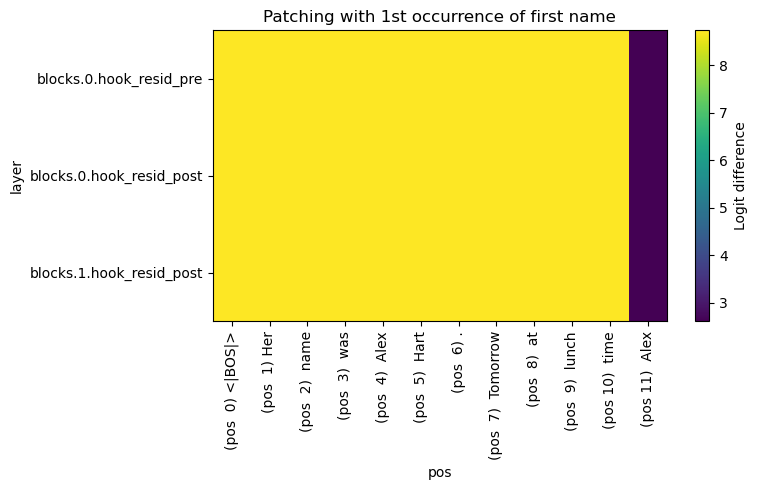

In [31]:
import matplotlib.pyplot as plt

model_2l = HookedTransformer.from_pretrained("gelu-2l")

clean_prompt = "Her name was Alex Hart. Tomorrow at lunch time Alex"
clean_tokens = model_2l.to_str_tokens(clean_prompt)

# Indices of the right and wrong answers (lastnames) to judge what the model predicts
clean_answer_index = model_2l.tokenizer.encode(" Hart")[0]
corrupt_answer_index = model_2l.tokenizer.encode(" Carroll")[0]

def patch_residual_stream(activations, hook, layer="blocks.6.hook_resid_post", pos=5):
   # The residual stream dimensions are [batch, position, d_embed]
   activations[:, pos, :] = corrupt_cache[layer][:, pos, :]
   return activations

layers = ["blocks.0.hook_resid_pre", *[f"blocks.{i}.hook_resid_post" for i in range(model_2l.cfg.n_layers)]]
n_layers = len(layers)
n_pos = len(clean_tokens)


for corrupt_prompt in ["Her name was Alex Carroll. Tomorrow at lunch time Alex",
                       "Her name was Sarah Hart. Tomorrow at lunch time Alex",
                       "Her name was Alex Hart. Tomorrow at lunch time Sarah"]:
    corrupt_tokens = model_2l.to_str_tokens(corrupt_prompt)
    _, corrupt_cache = model_2l.run_with_cache(corrupt_prompt)

    # Test this patch at any layer and any position
    patching_effect = torch.zeros(n_layers, n_pos)
    for l, layer in enumerate(layers):
        for pos in range(n_pos):
            torch.cuda.empty_cache()
            fwd_hooks = [(layer, partial(patch_residual_stream, layer=layer, pos=pos))]
            prediction_logits = model_2l.run_with_hooks(clean_prompt, fwd_hooks=fwd_hooks)[0, -1]
            patching_effect[l, pos] = prediction_logits[clean_answer_index] - prediction_logits[corrupt_answer_index]

    # Plot
    token_labels = [f"(pos {i:2}) {t}" for i, t in enumerate(clean_tokens)]

    # Convert 'patching_effect' to a NumPy array if it's a PyTorch tensor
    patching_effect = patching_effect.detach().numpy()  # Uncomment if patching_effect is a tensor
    
    plt.figure(figsize=(8, 5))  # Adjust the figure size as needed
    plt.imshow(patching_effect, aspect='auto', cmap='viridis')  # 'cmap' can be changed as per preference
    
    plt.xticks(ticks=range(len(token_labels)), labels=token_labels, rotation='vertical')
    plt.yticks(ticks=range(len(layers)), labels=layers)
    plt.xlabel("pos")
    plt.ylabel("layer")
    plt.colorbar(label="Logit difference")
    plt.title("Patching with 1st occurrence of first name")
    
    plt.tight_layout()  # Adjust layout to fit everything
    plt.show()

# Method 2: Attention head patching

In [32]:
model_2l.cfg.use_attn_result = True

In [33]:
clean_prompt = "Her name was Alex Hart. Tomorrow at lunch time Alex"
corrupt_prompt = "Her name was Alex Carroll. Tomorrow at lunch time Alex"
clean_tokens = model_2l.to_str_tokens(clean_prompt)
_, corrupt_cache = model_2l.run_with_cache(corrupt_prompt)

clean_answer_index = model_2l.tokenizer.encode(" Hart")[0]
corrupt_answer_index = model_2l.tokenizer.encode(" Carroll")[0]

n_layers = model_2l.cfg.n_layers
n_heads = model_2l.cfg.n_heads
n_pos = len(clean_tokens)

def patch_head_result(activations, hook, layer=None, head=None):
   activations[:, :, head, :] = corrupt_cache[hook.name][:, :, head, :]
   return activations

patching_effect = torch.zeros(n_layers, n_heads)
for layer in range(n_layers):
    for head in range(n_heads):
       fwd_hooks = [(f"blocks.{layer}.attn.hook_result", partial(patch_head_result, layer=layer, head=head))]
       prediction_logits = model_2l.run_with_hooks(clean_prompt, fwd_hooks=fwd_hooks)[0, -1]
       patching_effect[layer, head] = prediction_logits[clean_answer_index] - prediction_logits[corrupt_answer_index]

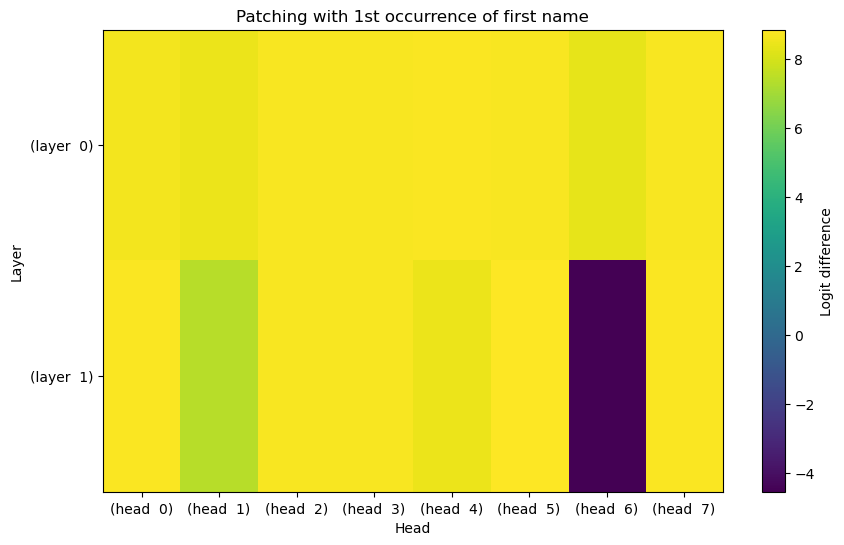

In [38]:
# Assuming head_labels, layer_labels, and patching_effect are defined as per your input
head_labels = [f"(head {i:2})" for i in range(n_heads)]
layer_labels = [f"(layer {i:2})" for i in range(n_layers)]

# Convert patching_effect to a NumPy array if it's not already
patching_effect = patching_effect.detach().numpy()

# Create the plot
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
im = plt.imshow(patching_effect, aspect='auto', cmap='viridis')  # Use a colormap of your choice

# Set the labels for x and y axes
plt.xticks(ticks=range(len(head_labels)), labels=head_labels)
plt.yticks(ticks=range(len(layer_labels)), labels=layer_labels)

# Add color bar, labels, and title
plt.colorbar(im, label="Logit difference")
plt.xlabel("Head")
plt.ylabel("Layer")
plt.title("Patching with 1st occurrence of first name")

plt.show()

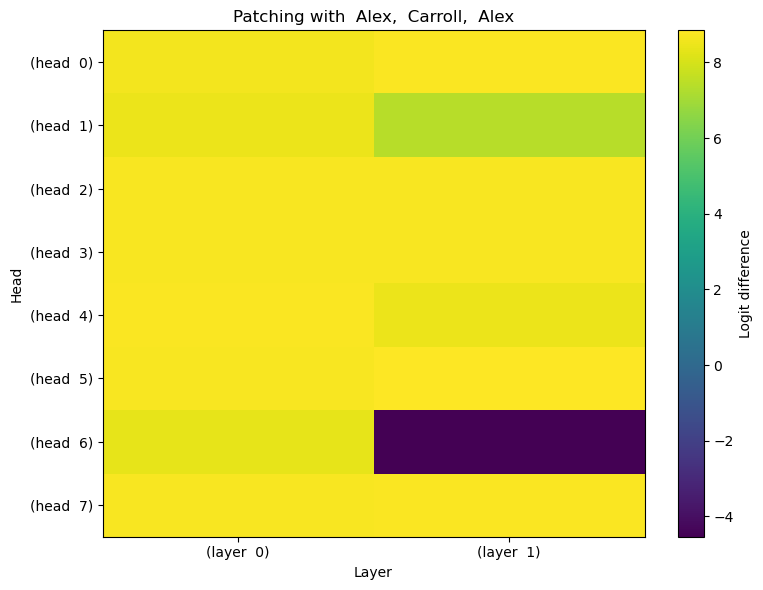

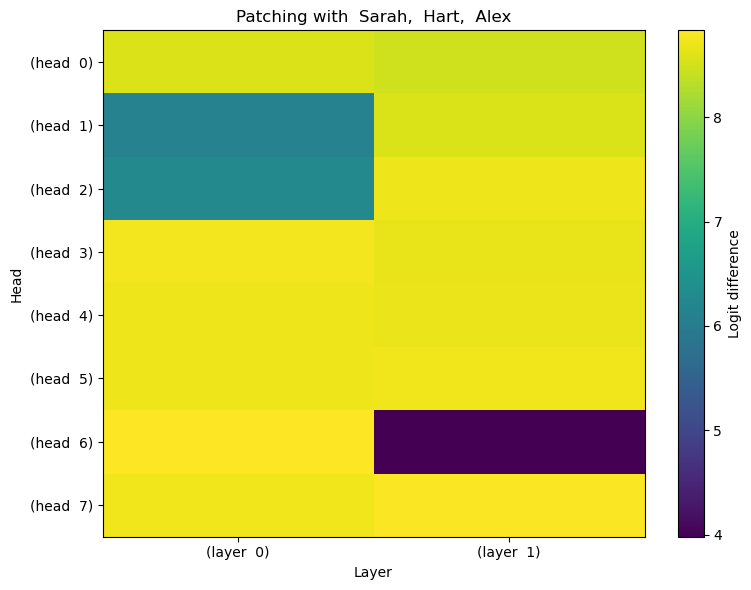

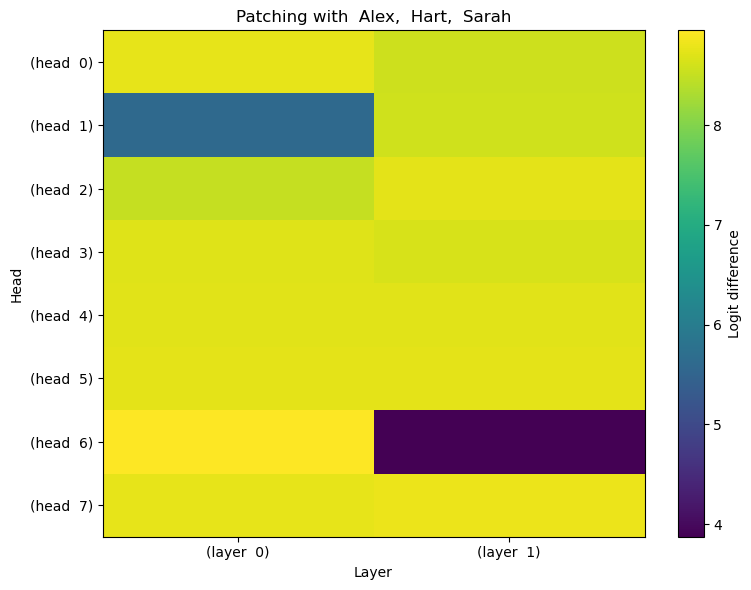

In [40]:
model_2l.cfg.use_attn_result = True


clean_prompt = "Her name was Alex Hart. Tomorrow at lunch time Alex"
clean_tokens = model_2l.to_str_tokens(clean_prompt)

# Indices of the right and wrong answers (lastnames) to judge what the model predicts
clean_answer_index = model_2l.tokenizer.encode(" Hart")[0]
corrupt_answer_index = model_2l.tokenizer.encode(" Carroll")[0]


n_layers = model_2l.cfg.n_layers
n_heads = model_2l.cfg.n_heads
n_pos = len(clean_tokens)

def patch_head_result(activations, hook, layer=None, head=None):
   activations[:, :, head, :] = corrupt_cache[hook.name][:, :, head, :]
   return activations



for corrupt_prompt in ["Her name was Alex Carroll. Tomorrow at lunch time Alex",
                       "Her name was Sarah Hart. Tomorrow at lunch time Alex",
                       "Her name was Alex Hart. Tomorrow at lunch time Sarah"]:
    corrupt_tokens = model_2l.to_str_tokens(corrupt_prompt)
    _, corrupt_cache = model_2l.run_with_cache(corrupt_prompt)

    patching_effect = torch.zeros(n_layers, n_heads)
    for layer in range(n_layers):
        for head in range(n_heads):
           fwd_hooks = [(f"blocks.{layer}.attn.hook_result", partial(patch_head_result, layer=layer, head=head))]
           prediction_logits = model_2l.run_with_hooks(clean_prompt, fwd_hooks=fwd_hooks)[0, -1]
           patching_effect[layer, head] = prediction_logits[clean_answer_index] - prediction_logits[corrupt_answer_index]

    # Plot
    # Assuming head_labels, layer_labels, n_heads, n_layers, patching_effect, and corrupt_tokens are defined
    head_labels = [f"(head {i:2})" for i in range(n_heads)]
    layer_labels = [f"(layer {i:2})" for i in range(n_layers)]
    
    # Transpose patching_effect if it's not already transposed
    patching_effect_transposed = patching_effect.T
    
    # Convert to NumPy array if it's a tensor
    patching_effect_transposed = patching_effect_transposed.detach().numpy()
    
    # Create the plot
    plt.figure(figsize=(8, 6))  # Adjust the figure size as needed
    im = plt.imshow(patching_effect_transposed, aspect='auto', cmap='viridis')  # Choose a colormap
    
    # Set the labels for x and y axes
    plt.xticks(ticks=range(len(layer_labels)), labels=layer_labels)
    plt.yticks(ticks=range(len(head_labels)), labels=head_labels)
    
    # Add color bar, labels, and title
    plt.colorbar(im, label="Logit difference")
    plt.xlabel("Layer")
    plt.ylabel("Head")
    plt.title(f"Patching with {corrupt_tokens[4]}, {corrupt_tokens[5]}, {corrupt_tokens[11]}")
    
    plt.tight_layout()  # Adjust layout
    plt.show()


# Attention head patching by position

In [41]:
clean_prompt = "Her name was Alex Hart. Tomorrow at lunch time Alex"
corrupt_prompt = "Her name was Alex Carroll. Tomorrow at lunch time Alex"
corrupt_tokens = model_2l.to_str_tokens(corrupt_prompt)
clean_tokens = model_2l.to_str_tokens(clean_prompt)
_, corrupt_cache = model_2l.run_with_cache(corrupt_prompt)

clean_answer_index = model_2l.tokenizer.encode(" Hart")[0]
corrupt_answer_index = model_2l.tokenizer.encode(" Carroll")[0]

n_layers = model_2l.cfg.n_layers
n_heads = model_2l.cfg.n_heads
n_pos = len(clean_tokens)

def patch_head_result(activations, hook, layer=None, head=None, pos=None):
   activations[:, pos, head, :] = corrupt_cache[hook.name][:, pos, head, :]
   return activations

patching_effect = torch.zeros(n_layers*n_heads, n_pos)
for layer in range(n_layers):
    for head in range(n_heads):
      for pos in range(n_pos):
          fwd_hooks = [(f"blocks.{layer}.attn.hook_result", partial(patch_head_result, layer=layer, head=head, pos=pos))]
          prediction_logits = model_2l.run_with_hooks(clean_prompt, fwd_hooks=fwd_hooks)[0, -1]
          patching_effect[n_heads*layer+head, pos] = prediction_logits[clean_answer_index] - prediction_logits[corrupt_answer_index]

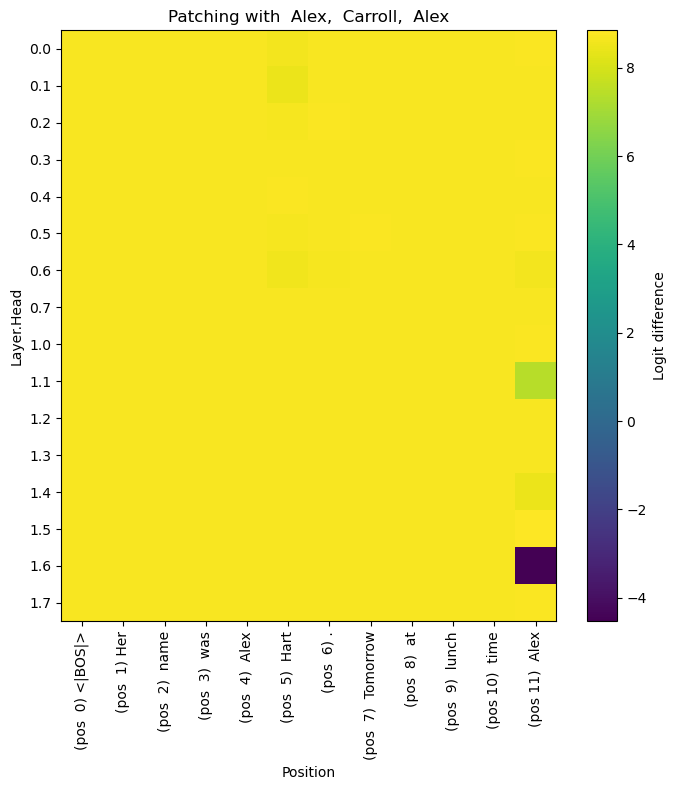

In [42]:
import matplotlib.pyplot as plt

token_labels = [f"(pos {i:2}) {t}" for i, t in enumerate(clean_tokens)]
layerhead_labels = [f"{l}.{h}" for l in range(n_layers) for h in range(n_heads)]

# Convert patching_effect to a NumPy array if it's not already
patching_effect = patching_effect.detach().numpy()

# Create the plot
plt.figure(figsize=(7, 8))  # Adjust the figure size as needed
im = plt.imshow(patching_effect, aspect='auto', cmap='viridis')  # Use a colormap of your choice

# Set the labels for x and y axes
plt.xticks(ticks=range(len(token_labels)), labels=token_labels, rotation='vertical')
plt.yticks(ticks=range(len(layerhead_labels)), labels=layerhead_labels)

# Add color bar, labels, and title
plt.colorbar(im, label="Logit difference")
plt.xlabel("Position")
plt.ylabel("Layer.Head")
plt.title(f"Patching with {corrupt_tokens[4]}, {corrupt_tokens[5]}, {corrupt_tokens[11]}")

plt.tight_layout()  # Adjust layout to fit everything
plt.show()

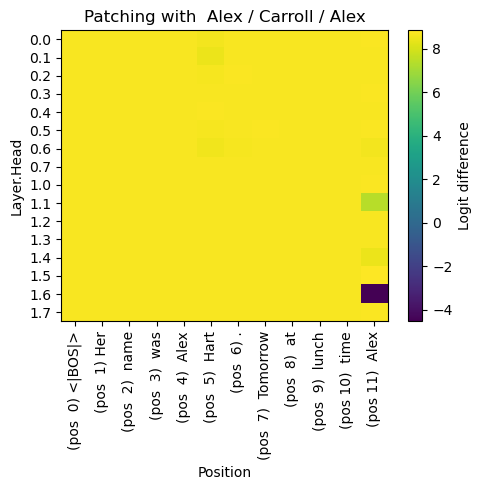

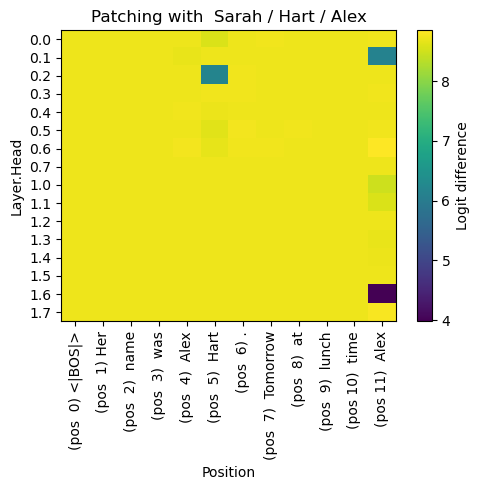

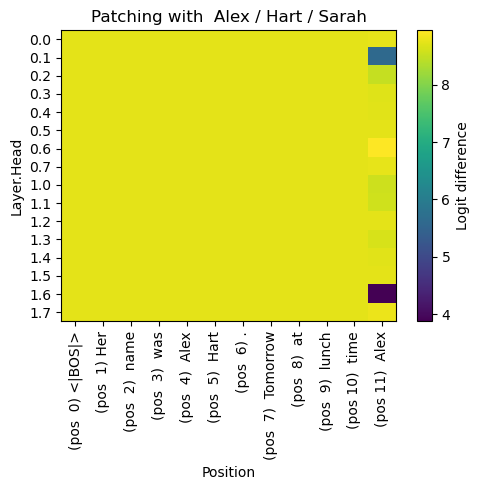

In [43]:
model_2l.cfg.use_attn_result = True


clean_prompt = "Her name was Alex Hart. Tomorrow at lunch time Alex"
clean_tokens = model_2l.to_str_tokens(clean_prompt)

# Indices of the right and wrong answers (lastnames) to judge what the model predicts
clean_answer_index = model_2l.tokenizer.encode(" Hart")[0]
corrupt_answer_index = model_2l.tokenizer.encode(" Carroll")[0]


n_layers = model_2l.cfg.n_layers
n_heads = model_2l.cfg.n_heads
n_pos = len(clean_tokens)

def patch_head_result(activations, hook, layer=None, head=None, pos=None):
   activations[:, pos, head, :] = corrupt_cache[hook.name][:, pos, head, :]
   return activations


for corrupt_prompt in ["Her name was Alex Carroll. Tomorrow at lunch time Alex",
                       "Her name was Sarah Hart. Tomorrow at lunch time Alex",
                       "Her name was Alex Hart. Tomorrow at lunch time Sarah"]:
    corrupt_tokens = model_2l.to_str_tokens(corrupt_prompt)
    _, corrupt_cache = model_2l.run_with_cache(corrupt_prompt)

    patching_effect = torch.zeros(n_layers*n_heads, n_pos)
    for layer in range(n_layers):
        for head in range(n_heads):
          for pos in range(n_pos):
              fwd_hooks = [(f"blocks.{layer}.attn.hook_result", partial(patch_head_result, layer=layer, head=head, pos=pos))]
              prediction_logits = model_2l.run_with_hooks(clean_prompt, fwd_hooks=fwd_hooks)[0, -1]
              patching_effect[n_heads*layer+head, pos] = prediction_logits[clean_answer_index] - prediction_logits[corrupt_answer_index]
    # Plot
    token_labels = [f"(pos {i:2}) {t}" for i, t in enumerate(clean_tokens)]
    layerhead_labels = [f"{l}.{h}" for l in range(n_layers) for h in range(n_heads)]
    
    # Convert patching_effect to a NumPy array if it's a tensor
    patching_effect = patching_effect.detach().numpy()
    
    # Create the plot
    plt.figure(figsize=(5, 5))  # Size is in inches, adjust as needed for your specific requirements
    im = plt.imshow(patching_effect, aspect='auto', cmap='viridis')  # Choose a suitable colormap
    
    # Set the labels for x and y axes
    plt.xticks(ticks=range(len(token_labels)), labels=token_labels, rotation='vertical')
    plt.yticks(ticks=range(len(layerhead_labels)), labels=layerhead_labels)
    
    # Add color bar, labels, and title
    plt.colorbar(im, label="Logit difference")
    plt.xlabel("Position")
    plt.ylabel("Layer.Head")
    plt.title(f"Patching with {corrupt_tokens[4]} /{corrupt_tokens[5]} /{corrupt_tokens[11]}")
    
    plt.tight_layout()  # Adjust layout to fit everything
    plt.show()

# Method 3: Circuitsvis attention plots

In [46]:
!pip install circuitsvis

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 10.0 MB/s eta 0:00:00a 0:00:01


In [47]:
import circuitsvis as cv

prompt = "Her name was Alex Hart. Tomorrow at lunch time Alex"
_, cache = model_2l.run_with_cache(prompt)
cv.attention.attention_patterns(tokens=model_2l.to_str_tokens(prompt),
                                attention=cache[f'blocks.1.attn.hook_pattern'][0])

In [48]:
import circuitsvis as cv
layer = 1
cv.attention.attention_patterns(tokens=model_2l.to_str_tokens("Her name was Alex Hart. Tomorrow at lunch time Alex"),
                                attention=cache[f'blocks.{layer}.attn.hook_pattern'][0])